In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)

Project root: /shared/crollo/faers_signals


In [2]:
import duckdb
from faers_signals.config import WAREHOUSE_DB_PATH

con = duckdb.connect(str(WAREHOUSE_DB_PATH))

con.execute("SELECT COUNT(*) FROM signals_quarterly").fetchall()
con.execute("DESCRIBE signals_quarterly").fetchdf().head()
con.execute("""
    SELECT year, quarter, COUNT(*) AS n_pairs
    FROM signals_quarterly
    GROUP BY year, quarter
    ORDER BY year, quarter
""").fetchdf()

,year,quarter,n_pairs
0,2019,Q1,119149
1,2019,Q2,119574
2,2019,Q3,135940
3,2019,Q4,132569
4,2020,Q1,140188
5,2020,Q2,141924
6,2020,Q3,166059
7,2020,Q4,153757
8,2021,Q1,152782
9,2021,Q2,158349


In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from faers_signals.config import WAREHOUSE_DB_PATH

con = duckdb.connect(str(WAREHOUSE_DB_PATH))


## Single drug

In [4]:
drug = "ATORVASTATIN"

signals_q = con.execute("""
    SELECT *
    FROM signals_quarterly
    WHERE drugname_norm = ?
    ORDER BY pt, year, quarter_idx
""", [drug]).fetchdf()

signals_q.head()


,drugname_norm,pt,year,quarter,quarter_idx,total_reports,total_drug_reports,total_event_reports,n11,n10,n01,n00,ror,ror_ci_low,ror_ci_high,prr
0,ATORVASTATIN,AST/ALT ratio abnormal,2020,Q1,8081,384326,940,7,3,937,4,383382,318.065481,78.563115,1287.699080,316.886173
1,ATORVASTATIN,Abdominal adhesions,2019,Q4,8080,351969,793,34,3,790,31,351145,49.356315,16.322227,149.247149,49.143157
2,ATORVASTATIN,Abdominal adhesions,2020,Q1,8081,384326,940,43,3,937,40,383346,35.337291,11.835033,105.510828,35.209575
3,ATORVASTATIN,Abdominal discomfort,2019,Q1,8077,339887,765,2924,9,756,2915,336207,1.448135,0.762884,2.748904,1.442577
4,ATORVASTATIN,Abdominal discomfort,2019,Q2,8078,356922,652,2831,5,647,2826,353444,1.062173,0.458503,2.460639,1.061649


In [5]:
pt_counts = (
    signals_q.groupby("pt")["n11"]
    .sum()
    .sort_values(ascending=False)
)
top_pt = pt_counts.index[0]
top_pt, pt_counts[top_pt]


('Myalgia', np.int64(2333))

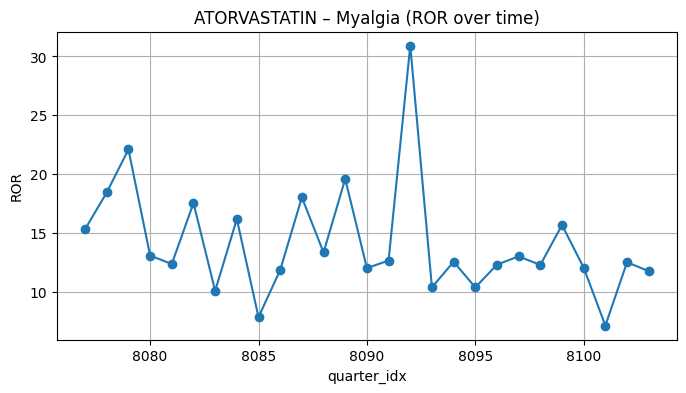

In [6]:
pt_df = signals_q[signals_q["pt"] == top_pt].copy()
pt_df = pt_df.sort_values("quarter_idx")

plt.figure(figsize=(8, 4))
plt.plot(pt_df["quarter_idx"], pt_df["ror"], marker="o")
plt.title(f"{drug} – {top_pt} (ROR over time)")
plt.xlabel("quarter_idx")
plt.ylabel("ROR")
plt.grid(True)
plt.show()


In [3]:
import duckdb
from faers_signals.config import WAREHOUSE_DB_PATH
from faers_signals.emergence import (
    EmergenceConfig,
    compute_emergence_scores_for_drug,
)

con = duckdb.connect(str(WAREHOUSE_DB_PATH))

cfg = EmergenceConfig(
    min_points=4,
    min_n11_latest=5,
)

emergence = compute_emergence_scores_for_drug("ATORVASTATIN", cfg=cfg, con=con)
emergence.head(20)

,pt,emergence_z,latest_ror,latest_ror_ci_low,latest_n11,n_points
0,Spinal stenosis,4.403801,24.455520,11.059970,6,5
1,Anosmia,3.953809,8.377131,4.383118,9,4
2,Diabetic ketoacidosis,3.205833,9.657188,5.594073,13,9
3,Cardiac failure acute,2.854421,31.625358,15.014293,7,7
4,Therapeutic product effect incomplete,2.757224,3.361093,2.343964,30,25
5,Coeliac disease,2.447010,32.246496,20.310229,20,4
6,Parkinson's disease,2.384886,15.824337,10.204345,21,6
7,Nephropathy,2.278262,9.998109,4.261118,5,7
8,White blood cell count increased,2.012866,7.688998,4.623634,15,10
9,"Hallucination, visual",1.943422,11.459382,7.252016,19,9


## Global

In [3]:
import duckdb
from faers_signals.config import WAREHOUSE_DB_PATH
from faers_signals.emergence import (
    EmergenceConfig,
    compute_global_emergence_scores,
)

con = duckdb.connect(str(WAREHOUSE_DB_PATH))

cfg = EmergenceConfig(
    min_points=4,
    min_n11_latest=5,
)

global_emergence = compute_global_emergence_scores(
    cfg=cfg,
    min_total_drug_reports=500,  # ignore extremely rare drugs
    max_drugs=None,
    con=con,
)

global_emergence.head(20)

[info] Computing global emergence for 3985 drugs (min_total_drug_reports=500)
[info] [1/3985] DUPIXENT (n_reports=364758)
[info] [2/3985] ZANTAC (n_reports=325161)
[info] [3/3985] PREDNISONE (n_reports=291409)
[info] [4/3985] HUMIRA (n_reports=277769)
[info] [5/3985] METHOTREXATE (n_reports=203080)
[info] [6/3985] ASPIRIN (n_reports=202115)
[info] [7/3985] REVLIMID (n_reports=192365)
[info] [8/3985] DEXAMETHASONE (n_reports=169924)
[info] [9/3985] OMEPRAZOLE (n_reports=164992)
[info] [10/3985] ATORVASTATIN (n_reports=161809)
[info] [11/3985] ACETAMINOPHEN (n_reports=161668)
[info] [12/3985] GABAPENTIN (n_reports=161385)
[info] [13/3985] RANITIDINE (n_reports=159490)
[info] [14/3985] METFORMIN (n_reports=149996)
[info] [15/3985] PROACTIV MD ADAPALENE ACNE TREATMENT (n_reports=149530)
[info] [16/3985] ELIQUIS (n_reports=146119)
[info] [17/3985] AMLODIPINE (n_reports=144950)
[info] [18/3985] FUROSEMIDE (n_reports=132868)
[info] [19/3985] PANTOPRAZOLE (n_reports=126032)
[info] [20/3985] EN

,drugname_norm,pt,signal_score,emergence_z,latest_ror,latest_ror_ci_low,latest_n11,n_points
0,EUMOVATE,Pyrexia,538.536777,93.432873,3.175851e+02,53.792267,6,4
1,TRIMETAZIDINE,Left ventricular hypertrophy,529.242581,48.736033,5.201826e+04,8904.212478,8,4
2,CLOZAPINE,Investigation noncompliance,520.054961,59.486525,6.261905e+03,375.520079,16,4
3,MEPOLIZUMAB,Mycobacterium avium complex infection,461.093127,79.113968,3.387513e+02,154.950946,8,4
4,PREDNISONE,Hepatitis viral,373.841665,85.961135,7.639804e+01,30.270154,9,5
5,PROMETHAZINE HYDROCHLORIDE,Viral test positive,337.766748,35.345812,1.412908e+04,5013.751843,7,4
6,TRIMETAZIDINE,Pulmonary valve disease,296.657849,19.546610,3.901789e+06,148217.559804,8,4
7,ALBUTEROL\IPRATROPIUM,Lactic acidosis,267.586257,46.231684,3.253404e+02,132.869802,7,4
8,KEPPRA,Pancytopenia,266.518863,81.988490,2.480805e+01,14.550128,14,4
9,PROTOPIC,Neuralgia,247.046130,38.560336,6.049165e+02,255.049544,8,4


In [4]:
filtered = global_emergence[
    (global_emergence["latest_ror"] >= 2.0) &
    (global_emergence["latest_ror_ci_low"] > 1.0) &
    (global_emergence["latest_n11"] >= 10)
].copy()

filtered.head(20)

,drugname_norm,pt,signal_score,emergence_z,latest_ror,latest_ror_ci_low,latest_n11,n_points
2,CLOZAPINE,Investigation noncompliance,520.054961,59.486525,6261.904962,375.520079,16,4
8,KEPPRA,Pancytopenia,266.518863,81.988490,24.808046,14.550128,14,4
11,CAMRELIZUMAB,Reactive capillary endothelial proliferation,214.032309,16.894413,317685.909091,18768.724443,17,5
20,TORSEMIDE,Pancreatic steatosis,144.784554,16.671289,5910.558707,2192.936962,14,4
25,EDOXABAN TOSYLATE,Mitral valve incompetence,131.082645,23.435702,267.617530,156.995133,16,4
26,FLUOXETINE,Ataxia,130.831231,31.005572,67.006539,38.808358,14,4
29,SIMVASTATIN,Seroma,124.067978,18.816251,729.450136,361.669037,14,5
30,PLAN B ONE?STEP,Pregnancy after post coital contraception,123.847211,10.721595,103899.952030,6201.864519,16,4
31,ACETYLSALICYLIC ACID,Tachypnoea,123.336644,31.926750,46.613344,27.737392,15,4
32,BLEOMYCIN,Acute respiratory distress syndrome,122.451149,24.258421,154.676342,91.020477,16,4


In [5]:
row = filtered.iloc[0]
row

drugname_norm                          CLOZAPINE
pt                   Investigation noncompliance
signal_score                          520.054961
emergence_z                            59.486525
latest_ror                           6261.904962
latest_ror_ci_low                     375.520079
latest_n11                                    16
n_points                                       4
Name: 2, dtype: object

In [6]:
drug = row["drugname_norm"]
pt = row["pt"]

ts = con.execute("""
    SELECT *
    FROM signals_quarterly
    WHERE drugname_norm = ?
      AND pt = ?
    ORDER BY quarter_idx
""", [drug, pt]).fetchdf()

ts[["year", "quarter", "n11", "ror", "ror_ci_low", "ror_ci_high"]]


,year,quarter,n11,ror,ror_ci_low,ror_ci_high
0,2022,Q3,4,711.254126,111.997217,4516.919680
1,2022,Q4,6,686.191966,159.435384,2953.293071
2,2024,Q4,5,738.241258,121.294680,4493.190926
3,2025,Q1,16,6261.904962,375.520079,104419.060182
